In [ ]:
import cv2
from projection.registry import ProjectionRegistry
from projection.processor import ProjectionProcessor

# Step 1: Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H,W,_ = equirect_img.shape
# Step 2: Retrieve and instantiate a Gnomonic projection config 
processor = ProjectionRegistry.get_projection("gnomonic", return_processor=True,  
                                              phi1_deg=0, 
                                              lam0_deg=0, 
                                              lat_points=H,
                                              lon_points=W,
                                              x_points=W//4,
                                              y_points=H//2,
                                              fov_deg=90)

# Step 4: Perform forward projection to rectilinear
rectilinear_img = processor.forward(equirect_img, phi1_deg=0, lam0_deg=0, fov_deg=(60, 60))
cv2.imwrite("rectilinear.png", rectilinear_img)

# Step 5: Perform backward projection to equirectangular
equirectangular_img = processor.backward(
    rectilinear_img,
    img_shape=equirect_img.shape,
    phi1_deg=0,
    lam0_deg=0,
    fov_deg=(60, 60),
    return_mask=True,
)
cv2.imwrite("equirectangular.png", equirectangular_img)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)
plt.show()

In [6]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
from projection.processor import ProjectionProcessor

# Step 1: Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H,W,_ = equirect_img.shape

# Step 2: Retrieve and instantiate a Gnomonic projection config 
processor = ProjectionRegistry.get_projection("gnomonic", return_processor=True,  
                                              phi1_deg=0, 
                                              lam0_deg=0, 
                                              lat_points=H,
                                              lon_points=W,
                                              x_points=W//4,
                                              y_points=H//2,
                                              fov_deg=30)

# Step 4: Perform forward projection to rectilinear
rectilinear_img = processor.forward(equirect_img)
cv2.imwrite("rectilinear.png", rectilinear_img)

# Step 5: Perform backward projection to equirectangular
equirectangular_img = processor.backward(
    rectilinear_img,
    return_mask=True,
)

# Step 6: Mask pixels outside the projection area
mask = np.mean(equirectangular_img,axis=-1) > 0

# Step 7: Compute the Mean Absolute Error 
mae_img = np.abs(equirect_img * mask[:,:,None] - equirectangular_img)
mae = np.mean(mae_img[mask]) 
print(mae)

2024-12-30 23:12:45,698 - gnomonic_projection.gnomonic.config - INFO - GnomonicConfig initialized successfully.
2024-12-30 23:12:45,700 - gnomonic_projection.gnomonic.strategy - INFO - GnomonicProjectionStrategy initialized successfully.
2024-12-30 23:12:45,701 - gnomonic_projection.gnomonic.grid - INFO - GnomonicGridGeneration initialized successfully.
2024-12-30 23:12:45,703 - gnomonic_projection.base.interpolation - INFO - BaseInterpolation initialized successfully.
2024-12-30 23:12:45,703 - gnomonic_projection.processor - INFO - ProjectionProcessor components initialized successfully.
2024-12-30 23:12:45,713 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2024-12-30 23:12:45,744 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
99.04950269868478


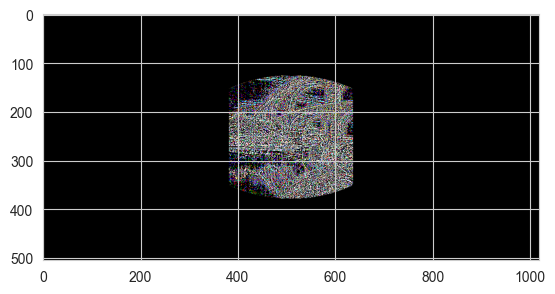

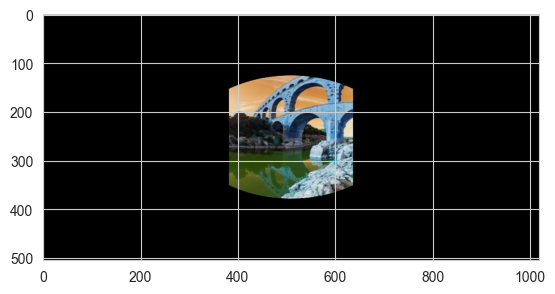

In [8]:
plt.imshow(mae_img )
plt.show()
plt.imshow(equirectangular_img)

In [ ]:
equirectangular_img.max()

In [1]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry

# Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H, W, _ = equirect_img.shape

# Convert the image from BGR to RGB
equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)

# Define the parameter grid
phi1_range = np.linspace(-90, 90, num=10)  # 10 steps from -90 to 90 degrees
lam0_range = np.linspace(-180, 180, num=10)  # 10 steps from -180 to 180 degrees
fov_range = np.linspace(10, 90, num=5)  # 5 steps from 10 to 90 degrees

# Initialize a dictionary to store results
results = []

# Perform the experiment
for phi1_deg in phi1_range:
    for lam0_deg in lam0_range:
        for fov_deg in fov_range:
            try:
                # Step 2: Instantiate the projection processor
                processor = ProjectionRegistry.get_projection(
                    "gnomonic",
                    return_processor=True,
                    phi1_deg=phi1_deg,
                    lam0_deg=lam0_deg,
                    lat_points=H,
                    lon_points=W,
                    x_points=W // 4,
                    y_points=H // 2,
                    fov_deg=fov_deg,
                )

                # Step 3: Perform forward projection to rectilinear
                rectilinear_img = processor.forward(equirect_img)

                # Step 4: Perform backward projection to equirectangular
                equirectangular_img = processor.backward(rectilinear_img, return_mask=True)

                # Step 5: Mask pixels outside the projection area
                mask = np.mean(equirectangular_img, axis=-1) > 0

                # Step 6: Compute the Mean Absolute Error
                mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
                mae = np.mean(mae_img[mask])

                # Store the result
                results.append({
                    "phi1_deg": phi1_deg,
                    "lam0_deg": lam0_deg,
                    "fov_deg": fov_deg,
                    "mae": mae
                })

                print(f"phi1_deg={phi1_deg}, lam0_deg={lam0_deg}, fov_deg={fov_deg}, MAE={mae}")

            except Exception as e:
                print(f"Error at phi1_deg={phi1_deg}, lam0_deg={lam0_deg}, fov_deg={fov_deg}: {e}")

# Save results to a file
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("experiment_results.csv", index=False)

print("Experiment completed. Results saved to 'experiment_results.csv'.")

2024-12-30 22:44:03,581 - gnomonic_projection - INFO - Initializing Gnomonic Projection Package
2024-12-30 22:44:03,585 - gnomonic_projection.registry - INFO - Projection 'gnomonic' registered successfully.
2024-12-30 22:44:03,591 - gnomonic_projection.default_projections - INFO - Default projection 'gnomonic' registered successfully.
2024-12-30 22:44:03,592 - gnomonic_projection - INFO - Default projections registered successfully.
2024-12-30 22:44:03,609 - gnomonic_projection.gnomonic.config - INFO - GnomonicConfig initialized successfully.
2024-12-30 22:44:03,610 - gnomonic_projection.gnomonic.strategy - INFO - GnomonicProjectionStrategy initialized successfully.
2024-12-30 22:44:03,614 - gnomonic_projection.gnomonic.grid - INFO - GnomonicGridGeneration initialized successfully.
2024-12-30 22:44:03,615 - gnomonic_projection.base.interpolation - INFO - BaseInterpolation initialized successfully.
2024-12-30 22:44:03,616 - gnomonic_projection.processor - INFO - ProjectionProcessor comp

In [3]:
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


Min Normalized MAE: 0.0, Max Normalized MAE: 1.0


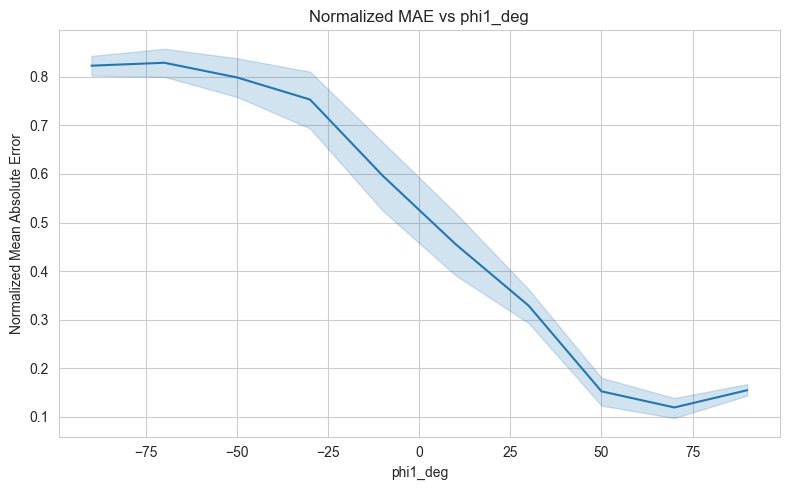

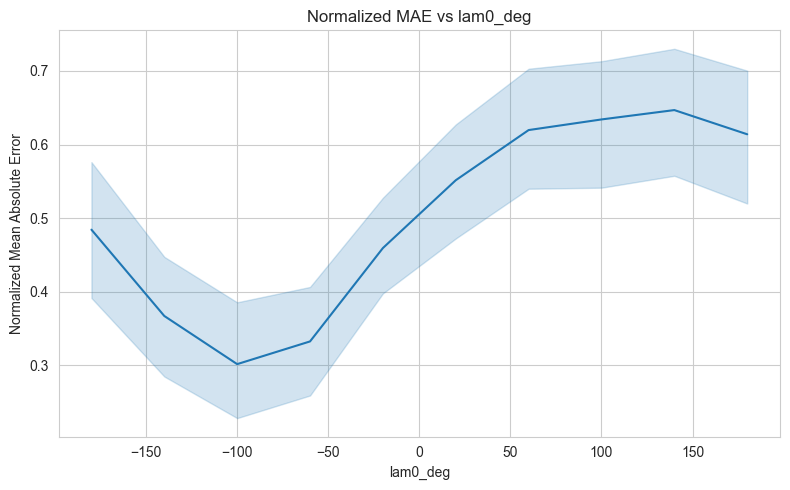

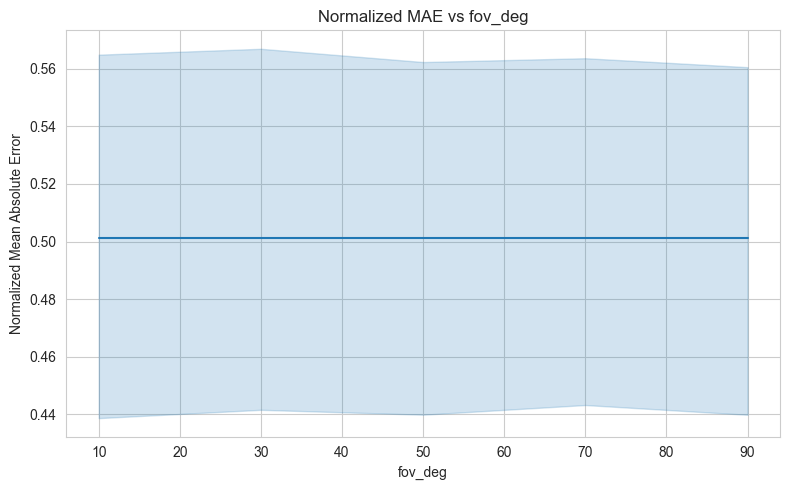

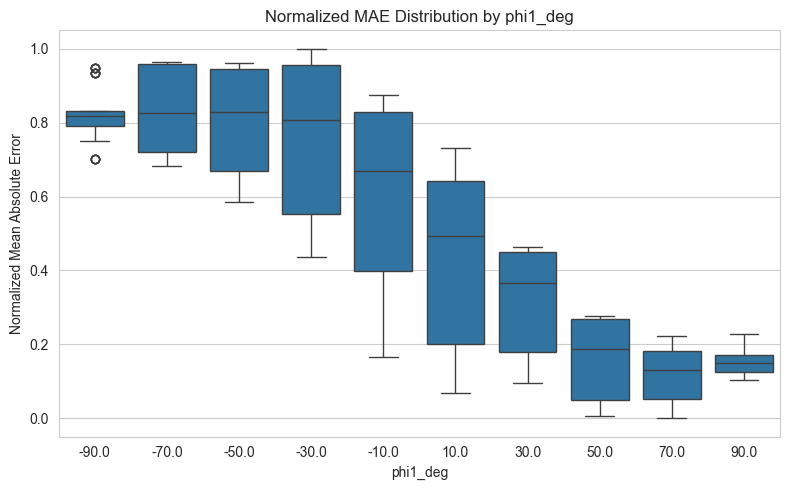

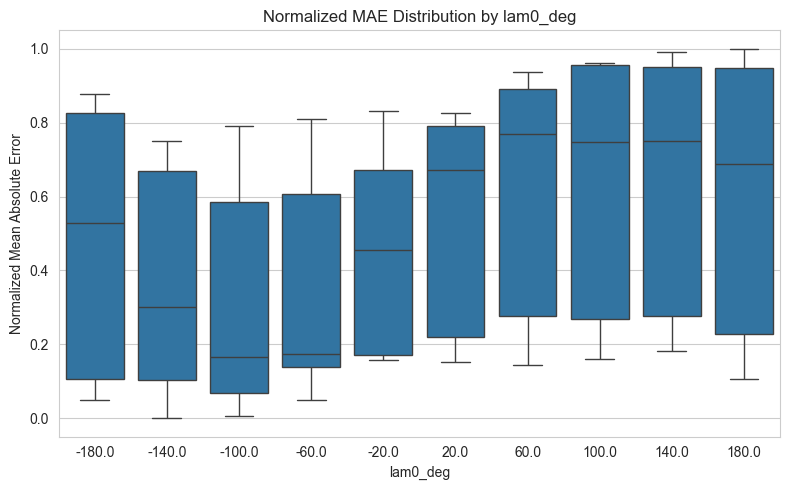

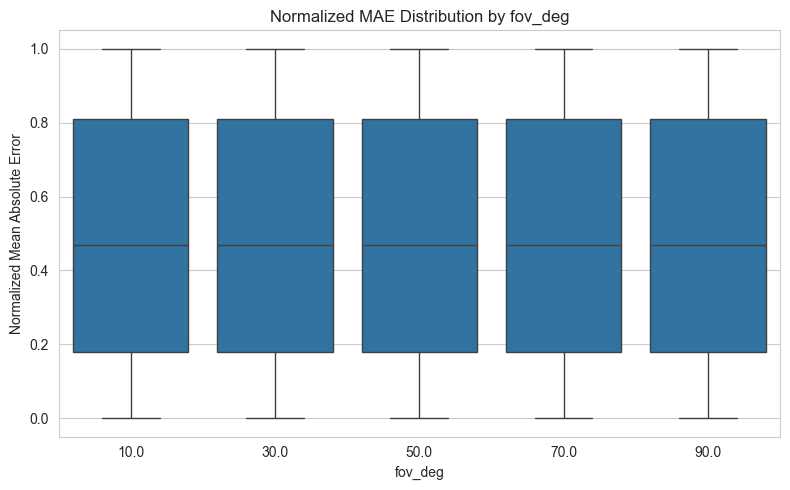

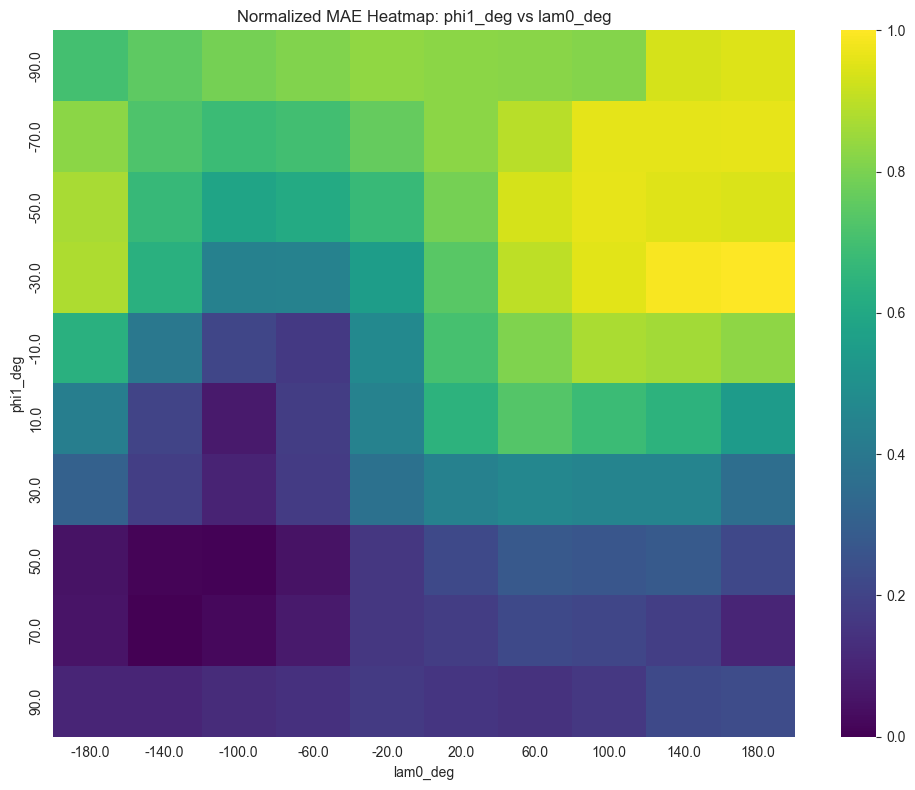

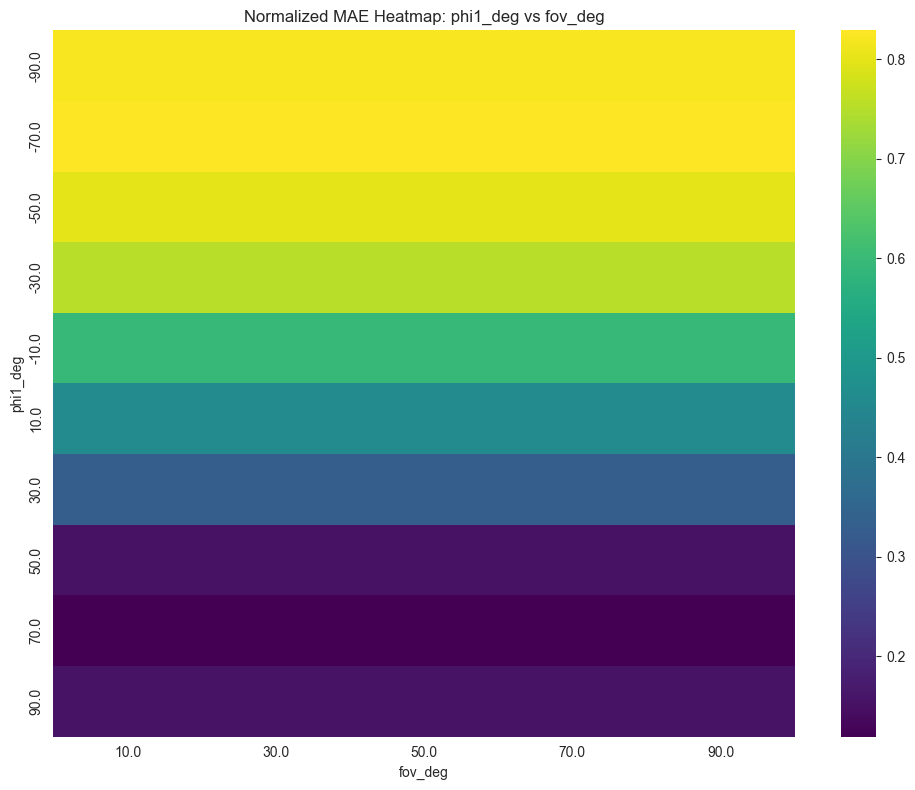

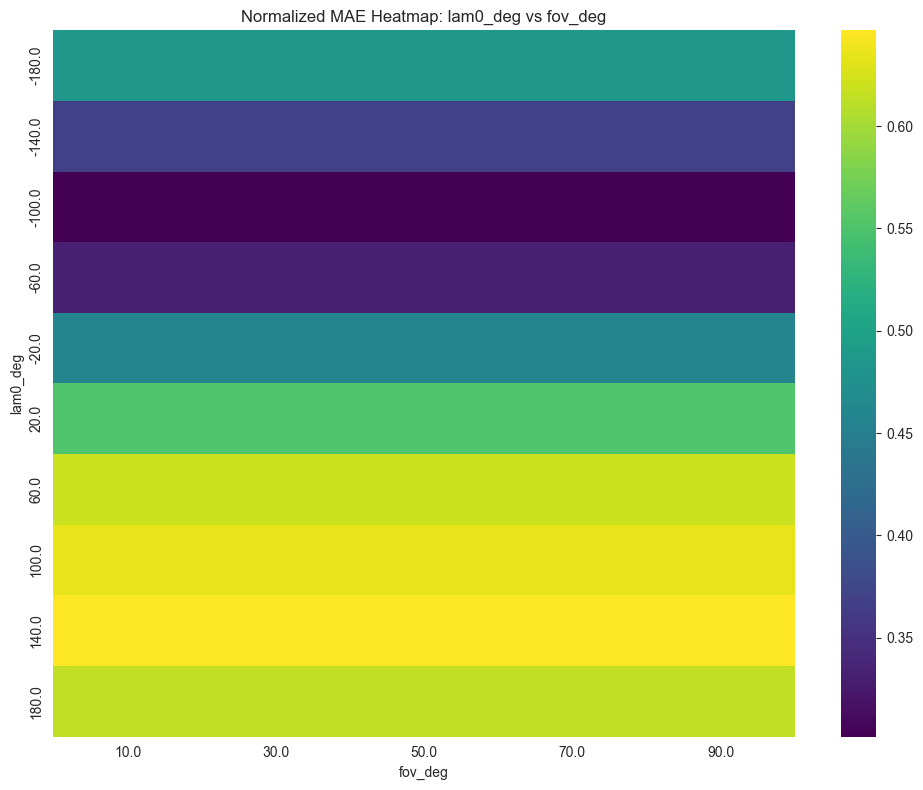

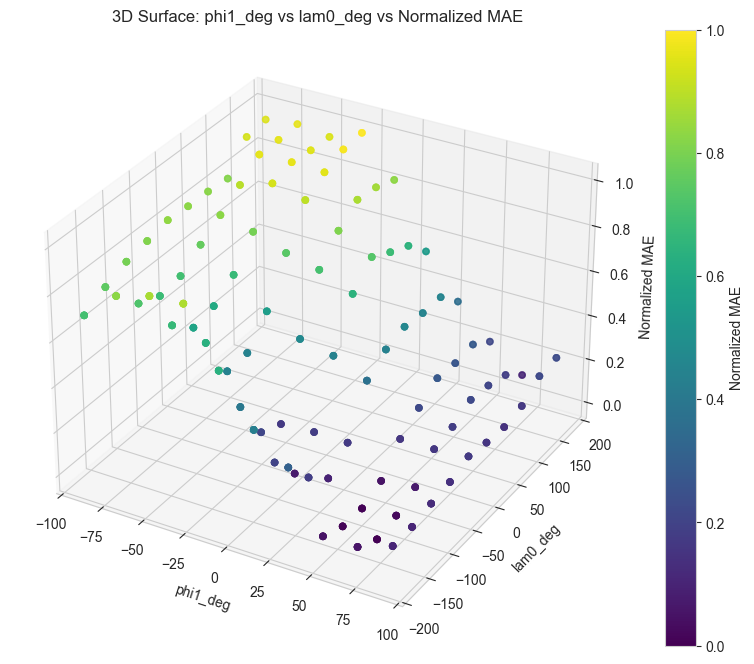

/var/folders/s0/nmmlypl91v5fywqz2m0_4xj40000gn/T/ipykernel_31985/1182076675.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x=param, y="normalized_mae", scale="width")


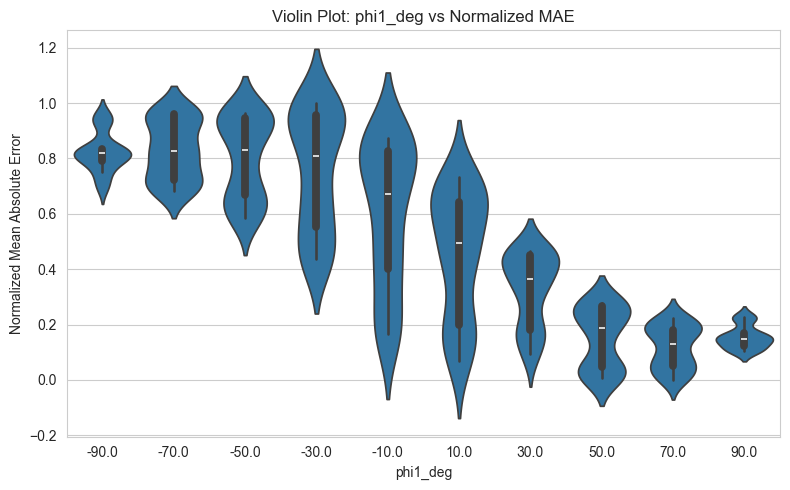

/var/folders/s0/nmmlypl91v5fywqz2m0_4xj40000gn/T/ipykernel_31985/1182076675.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x=param, y="normalized_mae", scale="width")


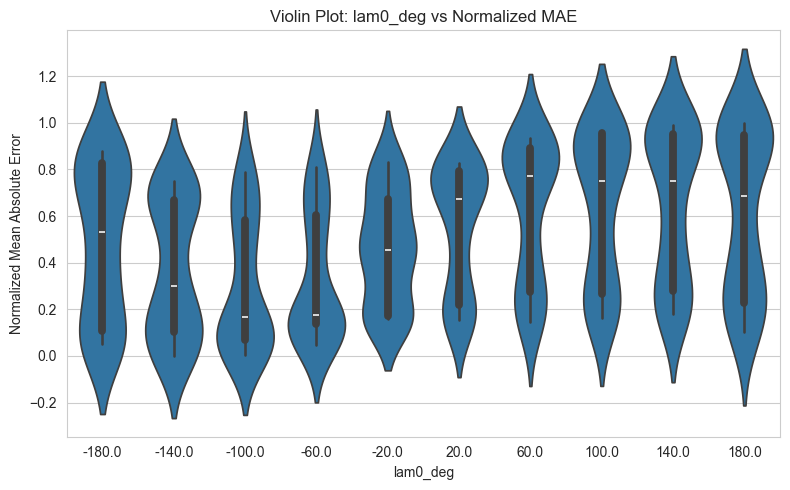

/var/folders/s0/nmmlypl91v5fywqz2m0_4xj40000gn/T/ipykernel_31985/1182076675.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x=param, y="normalized_mae", scale="width")


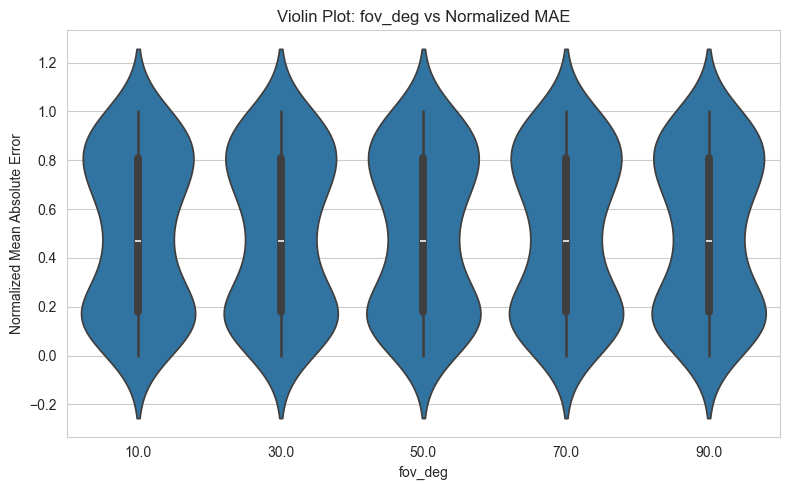

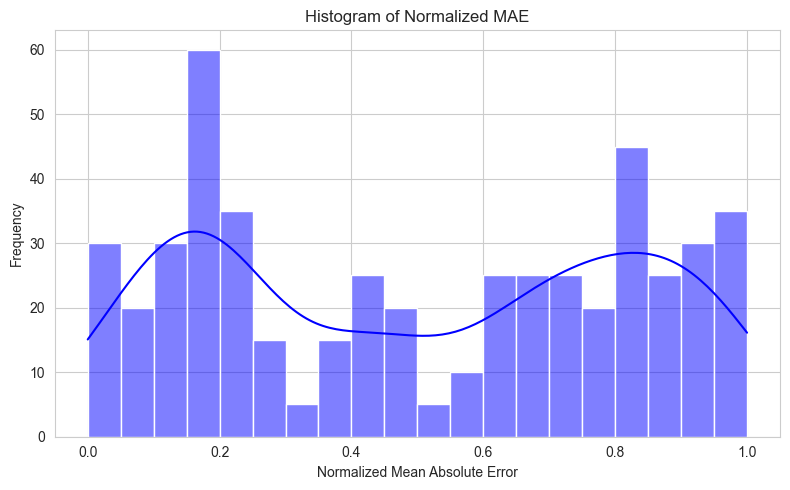

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the experimental results
df = pd.read_csv("experiment_results.csv")

# Normalize the MAE column
min_mae = df["mae"].min()
max_mae = df["mae"].max()
df["normalized_mae"] = (df["mae"] - min_mae) / (max_mae - min_mae)

# Ensure the normalization
print(f"Min Normalized MAE: {df['normalized_mae'].min()}, Max Normalized MAE: {df['normalized_mae'].max()}")

# Set global style
sns.set_style("whitegrid")

# 1. Line Charts for Each Parameter vs. Normalized MAE
parameters = ["phi1_deg", "lam0_deg", "fov_deg"]
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x=param, y="normalized_mae")
    plt.title(f"Normalized MAE vs {param}")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.show()

# 2. Box Plots for Each Parameter
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=param, y="normalized_mae")
    plt.title(f"Normalized MAE Distribution by {param}")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.show()

# 3. Heatmaps for Pairwise Parameter Interactions
pairs = [("phi1_deg", "lam0_deg"), ("phi1_deg", "fov_deg"), ("lam0_deg", "fov_deg")]

for param1, param2 in pairs:
    plt.figure(figsize=(10, 8))
    pivot = df.pivot_table(index=param1, columns=param2, values="normalized_mae", aggfunc="mean")
    sns.heatmap(pivot, cmap="viridis", annot=False)
    plt.title(f"Normalized MAE Heatmap: {param1} vs {param2}")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.tight_layout()
    plt.show()

# 4. 3D Surface Plots
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Example: phi1_deg vs lam0_deg vs normalized_mae
x = df["phi1_deg"]
y = df["lam0_deg"]
z = df["normalized_mae"]

scatter = ax.scatter(x, y, z, c=z, cmap="viridis", marker="o")
ax.set_title("3D Surface: phi1_deg vs lam0_deg vs Normalized MAE")
ax.set_xlabel("phi1_deg")
ax.set_ylabel("lam0_deg")
ax.set_zlabel("Normalized MAE")
plt.colorbar(scatter, ax=ax, label="Normalized MAE")
plt.show()

# 5. Violin Plots for Each Parameter
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df, x=param, y="normalized_mae", scale="width")
    plt.title(f"Violin Plot: {param} vs Normalized MAE")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.show()

# 6. General Distribution: Histogram of Normalized MAE
plt.figure(figsize=(8, 5))
sns.histplot(df["normalized_mae"], bins=20, kde=True, color="blue")
plt.title("Histogram of Normalized MAE")
plt.xlabel("Normalized Mean Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()